In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Dataset on my machine
Crime_5_7 = pd.read_csv('C://Users/kodur/Documents/Chicago_Crimes_2005_to_2007.csv.',
                        na_values = [None, 'NaN','Nothing'], header = 0) 
Crime_8_11 = pd.read_csv('C://Users/kodur/Documents/Chicago_Crimes_2008_to_2011.csv.',
                        na_values = [None, 'NaN','Nothing'], header = 0) 
Crime_12_17 = pd.read_csv('C://Users/kodur/Documents/Chicago_Crimes_2012_to_2017.csv.',
                        na_values = [None, 'NaN','Nothing'], header = 0)

In [3]:
#Demographic data of each zipcode
ZipCode_Data = pd.read_csv('C://Users/kodur/Documents/Chicago_Zip_Data.csv.', header = 0)

In [4]:
Crime_Data = [Crime_5_7, Crime_8_11, Crime_12_17]
del Crime_5_7
del Crime_8_11
del Crime_12_17
Crime_Data = pd.concat(Crime_Data,axis = 0)

In [5]:
#removing duplicate rows
Crime_Data.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

In [6]:
#removing non-predictive columns & redundant columns
Crime_Data.drop(['Unnamed: 0','Case Number','IUCR','FBI Code','Location',
                 'X Coordinate','Y Coordinate'], inplace = True, axis = 1)

In [7]:
#converting index to date of crime
Crime_Data.Date = pd.to_datetime(Crime_Data.Date, format = '%m/%d/%Y %I:%M:%S %p')
Crime_Data['Updated On'] = pd.to_datetime(Crime_Data['Updated On'], format = '%m/%d/%Y %I:%M:%S %p')
Crime_Data.index = pd.DatetimeIndex(Crime_Data.Date)

In [8]:
Groups = Crime_Data.groupby(Crime_Data['Primary Type'])
Groups = dict(list(Groups))

In [9]:
#grouping sex crimes together to look into
SexCrimes_Data = [Groups['CRIM SEXUAL ASSAULT'], Groups['HUMAN TRAFFICKING'],
                  Groups['OFFENSE INVOLVING CHILDREN'], Groups['PROSTITUTION'],
                  Groups['SEX OFFENSE'], Groups['STALKING']]
SexCrimes_Data = pd.concat(SexCrimes_Data, axis = 0)
del Groups
del Crime_Data

In [10]:
#Zipcode of each sex crime, found through geocoding
SexCrimeZipData = pd.read_csv('C://Users/kodur/Documents/ChicagoSexCrimesZipCodeData.csv',header = 0)
SexCrimes_Data = SexCrimes_Data.dropna(axis = 0, how = 'any')
SexCrimeZipData.index = pd.DatetimeIndex(SexCrimes_Data.index)

In [11]:
#adding zipcode data
SexCrimes_Data['ZipCode'] = SexCrimeZipData['ZipCode']

In [12]:
#converting data for each zipcode into list zipdata.
G = dict(ZipCode_Data)
keys = list(G.keys())
listdata = []
zipdata = []
for i in range(len(G[keys[0]])):
    for j in range(1,len(keys)):
        listdata.append(G[keys[j]][i])
    listdata = []
    zipdata.append(listdata)

In [13]:
#binary search algorithm to find zip code
def BinarySearch(item, L, data, low, high):
    mid = int(low + (high - low) / 2)
    if (item == L[mid]):
        return data[mid]
    elif (low == high):
        return None
    else:
        if (item < L[mid]):
            return BinarySearch(item, L, data, low, mid - 1)
        else:
            return BinarySearch(item, L, data, mid + 1, high)

In [14]:
#creating a list of the zipcode demographics of each location that the crime occurred in
SC_Data_Zip = list(SexCrimes_Data.ZipCode)
zdata = [None] * len(SC_Data_Zip)
for i in range(SexCrimeZipData.ZipCode.shape[0]):
    z = BinarySearch(SC_Data_Zip[i], ZipCode_Data.ZipCode, zipdata, 0, 84)
    zdata[i] = z

In [15]:
#concatenating the original data with the additional demographics data
zdata = pd.DataFrame(zdata[:], columns=keys[1:])
zdata.index = SexCrimes_Data.index
Data = [SexCrimes_Data, zdata]
Data = pd.concat(Data, axis = 1)

In [16]:
#Turning non-int variables into categorical variables
Data['Primary Type'] = pd.Categorical(Data['Primary Type'])
Data['Description'] = pd.Categorical(Data['Description'])
Data['Location Description'] = pd.Categorical(Data['Location Description'])
Data['ZipCode'] = pd.Categorical(Data['ZipCode'])

In [17]:
#Removing variables that are redundant about the geography of the location
Data.drop(['ID','Date','Block', 'Updated On','Beat','District','Ward','Community Area'], inplace = True, axis = 1)
#Adding variables about the time that each crime was reported at
Data['Month'] = Data.index.month
Data['Hour'] = Data.index.hour
Data['Day'] = Data.index.day
Data['Minute'] = Data.index.minute
SC_Data = Data.groupby('Primary Type')

In [18]:
#Splitting data by crime type
Data_By_Crime = [None] * 6
Data_By_Crime[0] = SC_Data.get_group('CRIM SEXUAL ASSAULT')
Data_By_Crime[1] = SC_Data.get_group('HUMAN TRAFFICKING')
Data_By_Crime[2] = SC_Data.get_group('OFFENSE INVOLVING CHILDREN')
Data_By_Crime[3] = SC_Data.get_group('PROSTITUTION')
Data_By_Crime[4] = SC_Data.get_group('SEX OFFENSE')
Data_By_Crime[5]= SC_Data.get_group('STALKING')

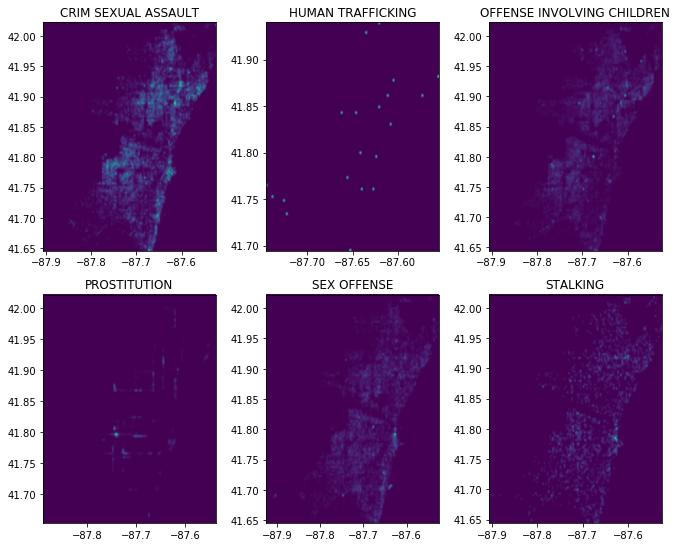

In [19]:
#Heatmap of sex crimes in Chicago between 2005 and 2017.
fig = plt.figure(figsize = (10,8))
d = dict(zip(range(6),Data['Primary Type'].unique()))
plt.axis('off')
for i in range(6):
    Data_By_Crime[i] = Data_By_Crime[i].dropna(how = 'any', axis = 0)
    x = Data_By_Crime[i]['Longitude']
    y = Data_By_Crime[i]['Latitude']
    a = fig.add_subplot(2,3,1+i)
    a.set_title('%s'%d[i])
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=120)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    a.imshow(heatmap.T, extent = extent, aspect = 'auto', interpolation = 'gaussian')
plt.tight_layout()
plt.show()

In [20]:
#animating graphs code
import matplotlib.animation as animation
from IPython.display import HTML
plt.switch_backend('tkagg')
Writer = animation.writers['ffmpeg']
#will save animations as mp4
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [21]:
#I segment by year and see if the clusters are moving/changing in anyway.
#I can then see if there is any overlap between the different sex crime types that I have selected, 
#and if there is, it might mean that the centroids of these clusters are hits for where the crime originates from.
#couldn't figure out how to get them simultaneous, so I just did them all individually instead of in a for loop
#Animation for Sexual Assault
Year_Data = Data_By_Crime[0].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (6,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'bessel', animated = True)
    plt.title('%s'%d[0])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('sex_assault.mp4', writer=writer)
plt.show()

In [22]:
#Animation for Human Trafficking
Year_Data = Data_By_Crime[1].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (6,4))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'binary', aspect = 'auto', interpolation = 'nearest', animated = True)
    plt.title('%s'%d[1])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('human_traff.mp4', writer=writer)
plt.show()

In [23]:
#Animation for Child Offenses
Year_Data = Data_By_Crime[2].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (5,7))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'nearest', animated = True)
    plt.title('%s'%d[2])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('child_offenses.mp4', writer=writer)
plt.show()

In [24]:
#Animation for Prostitution
Year_Data = Data_By_Crime[3].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (7,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=120)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'hamming', animated = True)
    plt.title('%s'%d[3])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('prostitution.mp4', writer=writer)
plt.show()

In [25]:
#Animation for Sex Offenses
Year_Data = Data_By_Crime[4].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (5,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'bessel', animated = True)
    plt.title('%s'%d[4])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('sex_offenses.mp4', writer=writer)
plt.show()

In [26]:
#Animation for Stalking
Year_Data = Data_By_Crime[5].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (5,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'bessel', animated = True)
    plt.title('%s'%d[5])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('stalking.mp4', writer=writer)
plt.show()

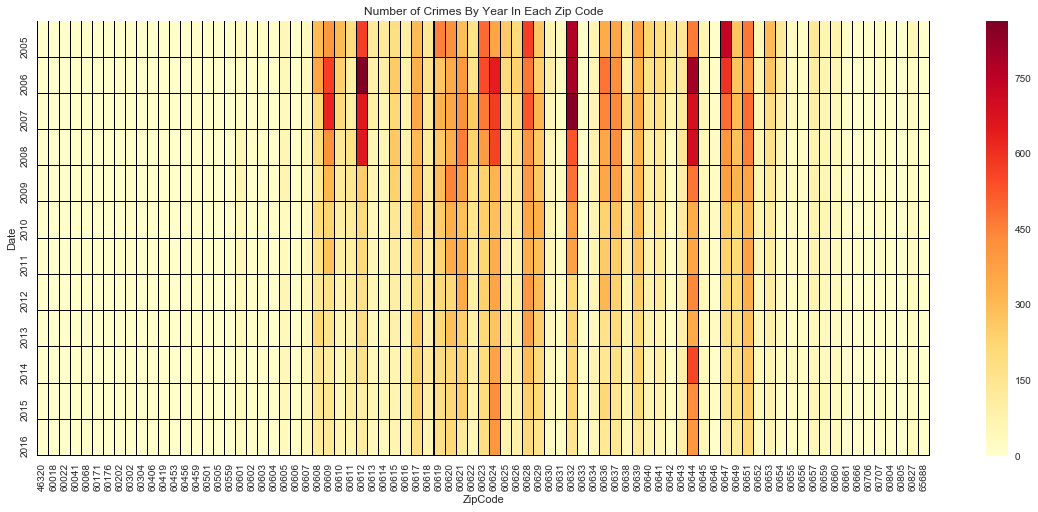

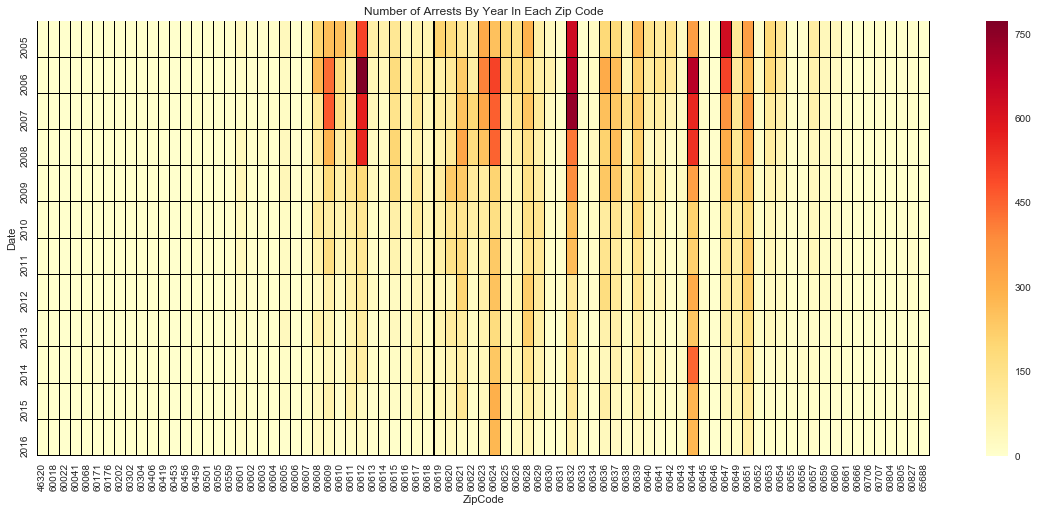

In [27]:
#return matplotlib back to inline viewings
%matplotlib inline
#Creating heatmaps for visualizing crime by zip code
import seaborn as sns
#Graph of Number of Crimes per zipcode and crime by zipcodes
Crime_By_Zip = Data.pivot_table('Arrest', aggfunc = np.size, columns = 'ZipCode',
                               index = Data.index.year, fill_value = 0)
plt.figure(figsize = (20,8))
plt.title('Number of Crimes By Year In Each Zip Code')
hm = sns.heatmap(Crime_By_Zip, cmap = 'YlOrRd', linewidth = 0.01, linecolor = 'k')
#Graph of Number of Arrests per zipcode and crime by zipcodes
Arrests_By_Zip = Data.pivot_table('Arrest', aggfunc = np.sum, columns = 'ZipCode',
                               index = Data.index.year, fill_value = 0)
plt.figure(figsize = (20,8))
plt.title('Number of Arrests By Year In Each Zip Code')
hm = sns.heatmap(Arrests_By_Zip, cmap = 'YlOrRd', linewidth = 0.01, linecolor = 'k')
plt.show()

In [28]:
#converting factors into their levels to be used for classification algorithms
Data['Primary Type'] = Data['Primary Type'].cat.codes
Data['Description'] = Data['Description'].cat.codes
Data['Location Description'] = Data['Location Description'].cat.codes
Data['ZipCode'] = Data['ZipCode'].cat.codes

In [29]:
#In the previous part, I tried to see if there was any way to discern whether an arrest would be made or not;
#therefore, in this one I will also try to do that given the new information about the zip code data.
#First, a GLM because the data has concrete boundaries on values
from sklearn import linear_model
#Importing PCA library
from sklearn.decomposition import PCA
pca = PCA()
reg = linear_model.LinearRegression()

In [30]:
#Separating Data into predictors and response dataframes
Data = Data.dropna(axis = 0, how = 'any')
Y = Data['Arrest']
Data.drop(['Arrest'], inplace = True, axis = 1)
#Using PCA to optimize fit for each algorithm
pca.fit(Data[0:28])
PCAData = pca.fit_transform(Data)
X = PCAData
print(pca.explained_variance_ratio_)

C:\Users\kodur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


[  7.81712590e-01   2.02142403e-01   1.27447839e-02   3.40001566e-03
   6.91592954e-08   4.71678323e-08   2.89953576e-08   1.96060171e-08
   1.26366339e-08   8.83067348e-09   6.77194760e-09   4.50546061e-09
   4.41824338e-09   1.49506814e-09   9.59873620e-10   9.19323111e-10
   9.05504365e-10   3.10505989e-10   2.78849215e-10   1.68738403e-10
   1.14456301e-10   1.16647339e-11   9.54814717e-13   7.08705292e-13
   4.07321293e-13   2.28521728e-13   1.04280591e-13   6.83447570e-33]


In [31]:
#Splitting Data randomly 80-20 training-test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30)

In [32]:
#GLM Least Squares Regression split along the decision border, converting probability of prediction to True or False
reg.fit(X_train,Y_train)
Reg_Expected_Y = reg.predict(X_test)
for i in range(len(Reg_Expected_Y)):
    if (Reg_Expected_Y[i] >= 0.5):
        Reg_Expected_Y[i] = True
    else:
        Reg_Expected_Y[i] = False

In [33]:
#Importing Confusion matrix and accuracy score reporting libraries
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
cm = confusion_matrix(Y_test, Reg_Expected_Y)

In [34]:
#copied confusion matrix plotting algorithm from scikit documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    with sns.axes_style("white"):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Arrest')
    plt.xlabel('Predicted Arrest')

Normalized confusion matrix
[[ 0.81863769  0.18136231]
 [ 0.18792581  0.81207419]]


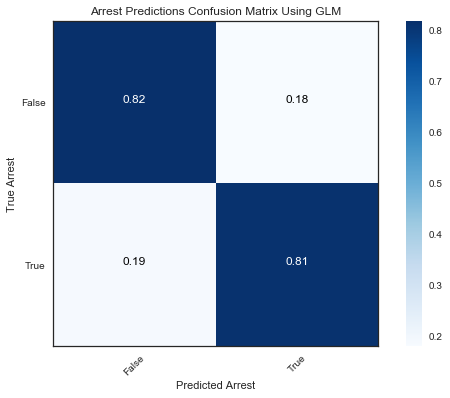

Accuracy of Model is: 0.815194


In [35]:
#Accuracy greatly increased compared to previous part of analyzing crime as a whole, population data for each zipcode
#is a helpful predictor to whether an arrest will be made
plt.figure()
plot_confusion_matrix(cm, normalize = True, classes = Y.unique(), title = 'Arrest Predictions Confusion Matrix Using GLM')
plt.show()
print("Accuracy of Model is: %f"%accuracy_score(Y_test, Reg_Expected_Y))

In [36]:
#Will now do the Naive Bayes to predict arrest probability
#Using Bernoulli because it can deal with discrete values better than the other types in scikitlearn
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()

In [37]:
#Fitting Naive Bayes Model to data and creating predictions
BNB.fit(X_train, Y_train)
BNB_Expected_Y = BNB.predict(X_test)

Normalized confusion matrix
[[ 0.75376097  0.24623903]
 [ 0.20855413  0.79144587]]


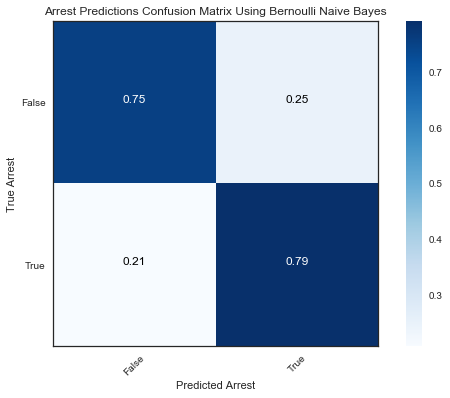

Accuracy of Model is: 0.773535


In [38]:
cm = confusion_matrix(Y_test, BNB_Expected_Y)
plt.figure()
plot_confusion_matrix(cm, normalize = True, classes = Y.unique(), 
                      title = 'Arrest Predictions Confusion Matrix Using Bernoulli Naive Bayes')
plt.show()
print("Accuracy of Model is: %f"%accuracy_score(Y_test, BNB_Expected_Y))

In [39]:
#Will now do Random Forest
from sklearn.ensemble import RandomForestClassifier

In [40]:
#testing oob score of random forests with sizes between 50 to 100 trees
OOB_Err = list(range(50,100))
for i in range(50,100):
    rfc = RandomForestClassifier(n_estimators = i, oob_score = True, n_jobs = -1)
    rfc.fit(X_train,Y_train)
    OOB_Err[i-50] = 1 - rfc.oob_score_

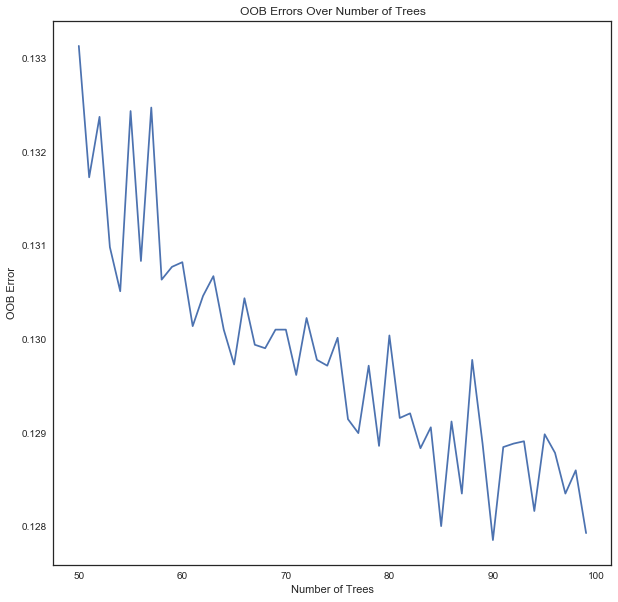

In [43]:
#plotting OOB Scores
plt.figure(figsize = (10,10))
with sns.axes_style("white"):
    plt.plot(list(range(50,100)), OOB_Err)
plt.title('OOB Errors Over Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.show()

In [44]:
rforest = RandomForestClassifier(n_estimators = 90, n_jobs = -1)
rforest.fit(X_train, Y_train)
RF_Expected_Y = rforest.predict(X_test)

Normalized confusion matrix
[[ 0.96207689  0.03792311]
 [ 0.20410674  0.79589326]]


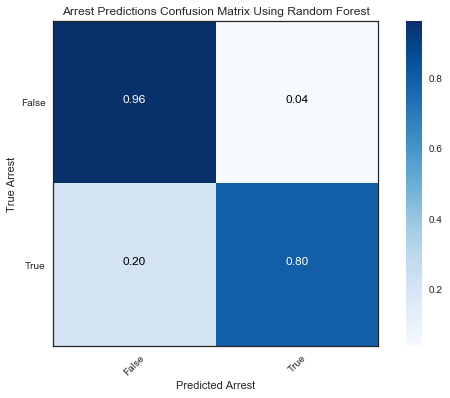

Accuracy of Model is: 0.874876


In [45]:
#Very accurate compared to previous project and much faster
#Running for cumulative crimes led to a 4-hour wait and an accuracy below 50%
cm = confusion_matrix(Y_test, RF_Expected_Y)
plt.figure()
plot_confusion_matrix(cm, normalize = True, classes = Y.unique(), 
                      title = 'Arrest Predictions Confusion Matrix Using Random Forest')
plt.show()
print("Accuracy of Model is: %f"%accuracy_score(Y_test, RF_Expected_Y))

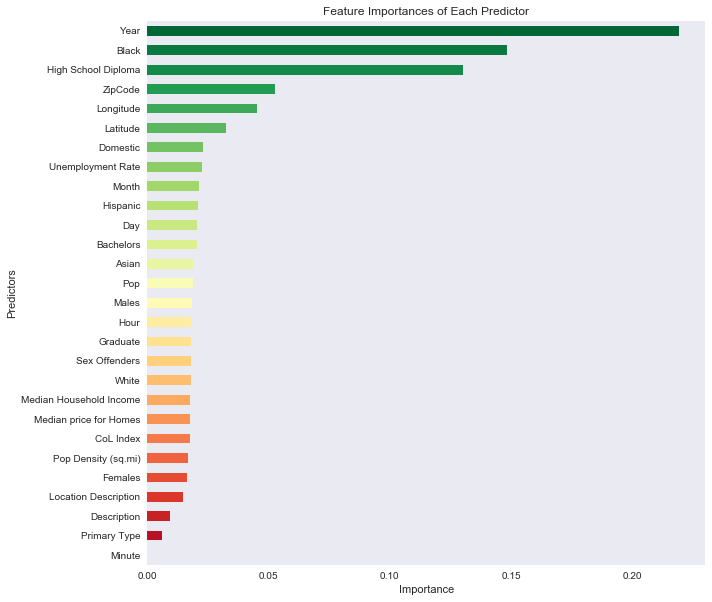

In [46]:
#Find most important variables in determining arrest rates Using Out of Bag Error
Col_Imp =[]
Col_Imp.append(list(Data.columns))
Col_Imp.append(list(rforest.feature_importances_))
Col_Imp = list(map(list, zip(*Col_Imp)))
Col_Imp = pd.DataFrame(Col_Imp, columns = ['Predictors','Feature Importances'])

#plot feature importance
Col_Imp.index = Col_Imp['Predictors']
colors = plt.cm.RdYlGn(np.linspace(0,1,len(Col_Imp)))
plt.title('Feature Importances of Each Predictor')
plt.xlabel('Importance')
with sns.axes_style("white"):
    Col_Imp['Feature Importances'].sort_values().plot(figsize = (10,10), kind = 'barh', color = colors)
plt.show()